In [2]:
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sai20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sai20\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sai20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# ***Importing the data set***

In [3]:
df = pd.read_csv("Reviews.csv",nrows=100000)
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'Reviews.csv'

# ***Dropping null and duplicate values***

In [3]:
df.drop_duplicates(subset=['Text'],keep='first')
df.dropna()
duplicates = df[df.duplicated()].sum().sum()
nulls = df[df.isnull()].sum().sum()
print("Number of duplicates are : ",duplicates,"\nNumber of null values :",nulls)

Number of duplicates are :  0.0 
Number of null values : 0.0


In [4]:
input_data = df.loc[:,'Text']
target_data = df.loc[:,'Summary']
target_data.replace('', np.nan, inplace=True)

# ***Preprocessing of data***

>Real-world texts are incomplete and they cannot be sent directly to the model that will cause certain errors. So, we clean all our texts and convert them into a presentable form for prediction tasks.


In [5]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]
contractions=pickle.load(open("contractions.pkl","rb"))['contractions']
#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

Some of our texts are in html format and contain html tags so first we will parse this text and remove all the html tags using ‘BeautifulSoup library’. After that, we tokenize our texts into words. And also check the following conditions:
1.   Contains integer
2.   are less than 3 words
3.   they are in stop words
If one of the above conditions matches, we will remove that particular word from the list of input or target words

We also have Contraction words in our input or target texts that are the combinations of two words.We will expand these kinds of words using the ‘contractions.pkl’ file which contains a dictionary having keys as shortened words and values as expanded words. Also we will stem all the input words to their root words.


>Stemming is the process of reducing words into their root words.

For example, if the text contains word like “chocollate” which might be misspelled for “chocolate”. If we don’t stem our words then the model will treat them as two different words. Stemmer will stem or reduce that error word to its root word i.e. “chocol”. As a result, “chocol” is the root word for both “chocolate” and “chocollate”.




In [1]:
def clean(texts,src):
  #removing the html tags
  texts = BeautifulSoup(texts,"lxml").text
  #tokenise the text into words
  words = word_tokenize(texts.lower())
  #filtering the words whichcontain '\'
  #filtering the integers or their length is less than or equal to 3
  words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
  #contractions file to list out shortened words
  words = [contractions[w] if w in contractions else w for w in words]
  #stemming the words to their root words and filtering stop_words
  if src=="inputs":
    words=[stemm.stem(w) for w in words if w not in stop_words]
  else:
    words=[w for w in words if w not in stop_words]
  return words

We will add **‘sos’** to the start and **‘eos’** at the end of target text to tell our model that this is the starting and ending of sentences

In [7]:
#pass input records and targget records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words = clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add "sos" and at the start and "eos" at the end of the text
  tr_words= clean("sos "+str(tr_txt)+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

<ipython-input-6-16fead7812ca>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  texts = BeautifulSoup(texts,"lxml").text


Now after cleaning the sentences we will filter duplicate words and sort them accordingly. Also we will store the total number of input and target words.

In [8]:
#store only unique words from input and target list
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #num of input words
num_tr_words = len(target_words) #num of target words

#get the length of the input and target texts which appears most often
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])

print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  32198
number of target words :  14193
maximum input length :  74
maximum target length :  17


# *Splitting the records*

In [9]:
# splitting the input and target data to 80:20 ratio for training and testing the machine
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0)

# *Text Vectorization*

We will convert our word into integer sequence using vectorization technique.

For example,

L = [ ‘what doing’, ‘how are you’, ’good ’]

Tokenize all the elements of list ‘L’ and make a dictionary having key as tokens and value as the counter number. So after the data is fit we get a dictionary as

D = { ‘what’ : 1 , ‘doing’ :2 , ‘how’ : 3 , ‘are’ : 4 , ‘you’ :5 , ‘good’ : 6 }

So we have fit our data, now let’s transform the below list ‘J’ into integer sequence using our tokenizer.

J = [ ‘what are you doing’, ‘you are good’ ]

Transformed (Vectorized) J : [ [ 1 , 4 , 5 , 2 ] , [ 5 , 4 , 6 ] ]

In [10]:
#training the tocenizer with all the words
in_tok= Tokenizer()
in_tok.fit_on_texts(str(x_train))
tr_tok= Tokenizer()
tr_tok.fit_on_texts(y_train)

#converting the text into a sequence of numbers
x_train=in_tok.texts_to_sequences(str(x_train))
y_train=tr_tok.texts_to_sequences(y_train)


After converting to integer sequence we will also make all the input and target texts to the same length for our model. So we will take the length of input sentences which has the highest frequency and store it in the ‘max_in_length’ variable, and repeat the same for target data also. Now we will pad arrays of 0’s to the texts if it is less than the assigned maximum input length.

Our encoder input data will be padded ‘x_train’ and decoder input data will be padded ‘y_train’ but we will not include the last word i.e ‘eos’. Decoder target data will be same as decoder input data but it will be one timestep ahead as it will not include the start word i.e. ‘sos’ of our target sentence.

In [11]:
#padding with array if length is less then maximum length
en_in_data=pad_sequences(x_train,maxlen=max_in_len,padding="post")
dec_data=pad_sequences(y_train,maxlen=max_tr_len,padding="post")

#decoder input data will not have the last word ,i.e.,"eos" in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one step ahead as it will not include "sos"
dec_tr_data=dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

# **Building a model**

We are using Stacked LSTM containing 3 layers of LSTM stacked on top of each other. This will make our prediction much better.

**Encoder**: We will initialize the encoder input tensor using the ‘Input’ object. The expected shape of the batch will be 74 (maximum input length)-dimensions. Then we will create an ‘Embedding Layer’ which will have the total number of input words as the first argument and a shape of 500 which is the latent(hidden) dimension.

In [12]:
K.clear_session()
latent_dim = 500

#create input object of total number of of encoder words
en_input= Input(shape=(max_in_len))
en_embedding= Embedding(num_in_words+1, latent_dim)(en_input)

**LSTM**: Now we will create 3 stacked LSTM layers where the first LSTM layer will have input of encoder and like that create a continuous sequence of LSTM layers.

The LSTM layer will capture all the contextual information present in the input sequence. We will return hidden state output and also states i.e. hidden state and cell state after execution of every LSTM layer.

In [13]:
#creating 3 stacked LSTM layers with the shape of hidden dimension for the text summarizer using deep learning

en_lstm1 = LSTM(latent_dim, return_state=True, return_sequences=True)
en_output1,state_h1,state_c1=en_lstm1(en_embedding)

en_lstm2 = LSTM(latent_dim, return_state=True, return_sequences=True)
en_output2,state_h2,state_c2=en_lstm2(en_output1)

en_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
en_output3,state_h3,state_c3=en_lstm3(en_output2)

en_states = [state_h3,state_c3]

Decoder: Like Encoder we will initialize the decoder input tensor and then pass it to the only LSTM. Here, the decoder will also have the initial state where we will pass the hidden state and cell state values that we have obtained from the encoder’s LSTM layer

In [14]:
dec_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_tr_words+1, latent_dim)
dec_embedding = dec_emb_layer(dec_inputs)

#initializing decoders LSTM using the output of the encoder
dec_lstm = LSTM(latent_dim,return_state=True,return_sequences=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states)

**Attention** **Layer**: We will pass the encoder and decoder outputs into the attention layer and then we will concatenate attention layer outputs with the decoder outputs

In [15]:
att = Attention()
att_out = att([dec_outputs,en_output3])

#concatenate the attention output with the decoder output
merge=Concatenate(axis=-1,name='concat_layer1')([dec_outputs,att_out])

Now we will create our Dense Layer that is the output layer for our model. It will have the shape of the total number of target words and a softmax activation function.

In [16]:
dec_dense = Dense(num_tr_words+1,activation='softmax')
dec_outputs = dec_dense(merge)

# **Train the Model**

Finally, we will initialize our Model class with input and output data from the encoder and decoder layers. We can plot the model layers and also get the summary of our model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 74)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 74, 500)              1609950   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 74, 500),            2002000   ['embedding[0][0]']           
                              (None, 500),                                                        
                              (None, 500)]                                                    

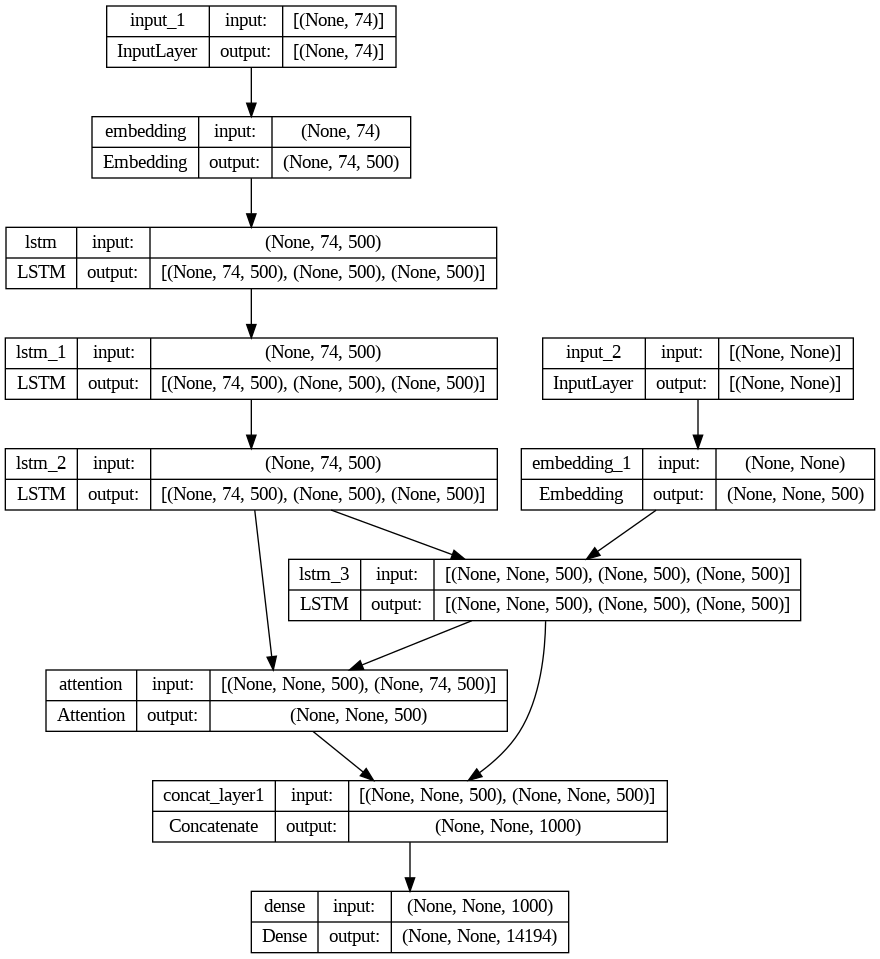

In [17]:
model = Model([en_input,dec_inputs],dec_outputs)
model.summary()
plot_model(model,to_file="model_plot.png",show_shapes=True,show_layer_names=True)

In [ ]:
model.compile(
    optimizer = "rmsprop", loss="sparse_categorical_crossentropy", metrics="accuracy"
)
model.fit(
    [en_in_data,dec_in_data],
    dec_tr_data,
    batch_size=512,
    epochs=10,
    validation_split=0.1
)
model.save("s2s")